In [29]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt 
from PIL import Image
import os

In [30]:
# Set device for training (GPU if available, else CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# =====================
# Data Preparation
# =====================
# Directory containing subfolders for each class
dataPath = r"C:\Users\TechWatt\Desktop\nutriscan dataset"

# Lists to store image file paths and corresponding labels
images = []
labels = []

# Get list of subfolders (each representing a class)
subFolders = os.listdir(dataPath)

In [31]:
# Iterate through subfolders and collect image paths and labels
for folder in subFolders:
    label = subFolders.index(folder)  # Assign an integer label per class
    path = os.path.join(dataPath, folder)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        images.append(img_path)  # Store file path, not loaded image
        labels.append(label)


In [32]:
# =====================
# Custom Dataset Class
# =====================
class DataPrep(Dataset):
    """
    Custom Dataset for loading images and labels.
    """
    def __init__(self, features, labels, transform=None):
        self.features = features  # List of image file paths
        self.labels = labels      # List of integer labels
        self.transform = transform

    def __getitem__(self, item):
        label = self.labels[item]
        img_path = self.features[item]
        try:
            image = Image.open(img_path).convert('RGB')  # Ensure 3 channels
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a zero tensor and -1 label if error occurs
            return torch.zeros(3, 200, 200), -1

    def __len__(self):
        return len(self.labels)


In [33]:
# =====================
# Image Transformations
# =====================
data_trans = transforms.Compose([
    transforms.Resize((200, 200)),  # Resize first
    transforms.ToTensor()           # Then convert to tensor
])


In [34]:
# =====================
# DataLoader
# =====================
dataset = DataPrep(images, labels, data_trans)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

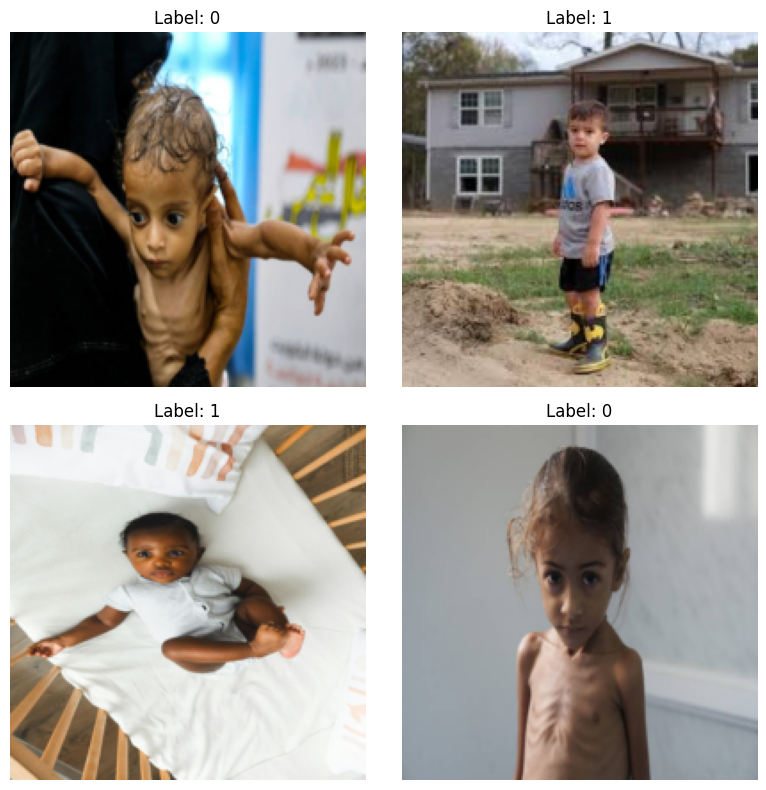

In [35]:

# Assume we have a DataLoader 'dataloader' with image data
images, labels = next(iter(data_loader))
# Plot the first 4 images
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [36]:
# =====================
# Model Definition
# =====================
class MalnutritionModel(nn.Module):
    """
    Simple CNN for binary classification (e.g., Cat vs Dog).
    """
    def __init__(self):
        super(MalnutritionModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64 * 50 * 50, 2)  # Output 2 classes

    def forward(self, data):
        data = self.conv1(data)
        data = self.activation(data)
        data = self.maxpool(data)
        data = self.activation(data)
        data = self.flatten(data)
        data = self.linear(data)
        return data


In [37]:
# =====================
# Training Loop
# =====================
def train():
    # Create model and move to device
    model = MalnutritionModel().to(device)
    print(model.eval())

    # Training parameters
    learning_rate = 0.001
    num_epochs = 50
    optimizer = optim.SGD(model.parameters(), learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        total_correct = 0
        total_samples = 0
        running_loss = 0.0
        for image, target in data_loader:
            # Skip samples with error (-1 label)
            mask = (target != -1)
            if mask.sum() == 0:
                continue
            image = image[mask].to(device)
            target = target[mask].to(device)

            optimizer.zero_grad()
            output = model(image)
            _, predicted = torch.max(output, 1)

            total_samples += target.size(0)
            total_correct += (predicted == target).sum().item()

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * target.size(0)

        accuracy = total_correct / total_samples if total_samples > 0 else 0
        avg_loss = running_loss / total_samples if total_samples > 0 else 0
        print(f'Epoch: {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}')

    # # Save the trained model
    torch.save(model.state_dict(), r'C:\Users\TechWatt\Desktop\techwatt\Nutri-Scan\model/malnutrition_model.pt')
    print('Model saved')

    return model

In [49]:
# =====================
# Run Inference
# =====================
def inference(model, image_path):
    """
    Run inference on a single image file.
    """
    image = Image.open(image_path).convert('RGB')
    input_image = data_trans(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_image)
    _, predicted_class = torch.max(output.data, 1)
    class_label_map = {0: 'Malnourished', 1: 'Nourished'}
    predicted_label = class_label_map.get(predicted_class.item(), 'Unknown')
    print('Predicted label:', predicted_label)
    return predicted_label


In [44]:
# =====================
# Main Guard
# =====================
if __name__ == "__main__":

    # Train the model
    # trained_model = train()
    pass

In [51]:
trained_model_path = r'C:\Users\TechWatt\Desktop\techwatt\Nutri-Scan\model\malnutrition_model.pt'

model = MalnutritionModel()
model.load_state_dict(torch.load(trained_model_path, map_location=device))
model = model.to(device)
model.eval()

#Runing inference
test_image_path = r"C:\Users\TechWatt\Desktop\nutriscan dataset\nourished\img41.jpg"
inference(model, test_image_path)

Predicted label: Nourished
tensor([2.0114], device='cuda:0')


'Nourished'